In [1]:
# pip install 

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyecharts import options as opts
from pyecharts.charts import Bar, Line, WordCloud
from wordcloud import WordCloud
import os
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

from pandas.errors import EmptyDataError
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [3]:



def load_data():
    # 获取目录路径
    author_dir = '../data/author/author.csv'
    video_dir = '../data/video/'
    comment_dir = '../data/comment/'

    # 读取作者信息
    try:
        author_df = pd.read_csv(author_dir)
    except Exception as e:
        print(f"读取作者文件时发生错误: {e}")
        author_df = pd.DataFrame()  # 如果读取失败，返回一个空的 DataFrame

    # 读取所有视频信息
    video_files = [f for f in os.listdir(video_dir) if f.endswith('_video.csv')]
    video_df_list = []
    for video_file in video_files:
        video_file_path = os.path.join(video_dir, video_file)
        
        # 检查视频文件是否为空
        if os.path.getsize(video_file_path) == 0:
            print(f"跳过空视频文件: {video_file_path}")
            continue
        
        try:
            video_data = pd.read_csv(video_file_path, on_bad_lines='skip')  # 跳过错误行
            video_data['author_id'] = video_file.split('_')[0]  # 添加作者ID
            video_df_list.append(video_data)
        except Exception as e:
            print(f"读取视频文件时发生错误: {e}")
    
    if video_df_list:  # 如果视频数据非空，进行拼接
        video_df = pd.concat(video_df_list, ignore_index=True)
    else:
        video_df = pd.DataFrame()  # 如果没有有效数据，返回空的 DataFrame

    # 读取所有评论信息
    comment_df_list = []
    required_columns = ['comment_id', 'author_name', 'content', 'create_time', 'create_time_text', 'like_count', 'reply_count', 'is_anonymous']
    
    for author_id in os.listdir(comment_dir):
        author_comments = os.path.join(comment_dir, author_id)
        if os.path.isdir(author_comments):
            for comment_file in os.listdir(author_comments):
                if comment_file.endswith('_comment.csv'):
                    comment_file_path = os.path.join(author_comments, comment_file)

                    try:
                        # 尝试读取评论文件
                        comment_data = pd.read_csv(comment_file_path, on_bad_lines='skip')  # 跳过错误行

                        comment_data['author_id'] = author_id  # 添加作者ID
                        comment_data['video_id'] = comment_file.split('_')[0]  # 添加视频ID
                        comment_df_list.append(comment_data)
                    except EmptyDataError:
                        # 特殊处理空数据的文件
                        print(f"评论文件为空，初始化空 DataFrame：{comment_file_path}")
                        # 加表头
                        empty_comment_data = pd.DataFrame(columns=required_columns)
                        empty_comment_data.to_csv(comment_file_path, index=False)
                        print(f"已创建空 DataFrame：{comment_file_path}")
                        empty_comment_data['author_id'] = author_id  # 添加作者ID
                        empty_comment_data['video_id'] = comment_file.split('_')[0]  # 添加视频ID
                        comment_df_list.append(empty_comment_data)
                    except Exception as e:
                        print(f"读取评论文件时发生错误: {e}")
                        print(f"跳过无效评论文件: {comment_file_path}")

    if comment_df_list:  # 如果评论数据非空，进行拼接
        comment_df = pd.concat(comment_df_list, ignore_index=True)
    else:
        comment_df = pd.DataFrame()  # 如果没有有效数据，返回空的 DataFrame

    return author_df, video_df, comment_df

# 加载数据
author_df, video_df, comment_df = load_data()

# 输出数据以验证
print("作者数据行数:", len(author_df))
print("视频数据行数:", len(video_df))
print("评论数据行数:", len(comment_df))



作者数据行数: 710
视频数据行数: 20981
评论数据行数: 271522


# (a) 描述统计分析

In [9]:



# 账号数据描述统计
author_desc = author_df.describe()

# 视频数据描述统计
video_desc = video_df.describe()

# 打印描述统计
print("账号数据描述统计:")
print(author_desc)
print("\n视频数据描述统计:")
print(video_desc)


账号数据描述统计:
       vip_status    fans_count   video_count
count  710.000000  7.100000e+02    710.000000
mean     1.073239  1.429500e+05   4055.826761
std      1.083399  3.067834e+05   5734.601078
min      0.000000  2.000000e+00      0.000000
25%      0.000000  2.287325e+04    548.750000
50%      1.000000  6.653800e+04   1245.500000
75%      1.750000  1.432855e+05   4863.250000
max      3.000000  4.987660e+06  32783.000000

视频数据描述统计:
                 id     like_count  comment_count    play_count
count  2.098100e+04   20981.000000   20981.000000  2.098100e+04
mean   8.733813e+18     542.867976      18.809971  3.429007e+04
std    4.711625e+18    4129.515859      91.341695  1.749536e+05
min    6.728563e+14       0.000000       0.000000  0.000000e+00
25%    5.036524e+18      12.000000       3.000000  1.289000e+03
50%    8.533356e+18      51.000000       6.000000  5.441000e+03
75%    1.224190e+19     224.000000      14.000000  2.096900e+04
max    1.844674e+19  350000.000000    8832.000000  1.

# (b) 相关性分析
我们首先通过皮尔逊相关系数矩阵来对数据进行相关性分析。

In [10]:
# 为了将相关列合并到一起，我们以 author_id 为关联键进行合并
merged_df = pd.merge(video_df, author_df, on='author_id', how='inner')

# 如果想把评论相关的数据也合并进来，以 video_id 为关联键（假设 comment_df 中有 video_id 列来关联视频）
# merged_df = pd.merge(merged_df, comment_df, on='video_id', how='inner')
# 将 vip_status 列转换为数值形式，假设 0 表示非认证，1 表示认证
merged_df['vip_status'] = merged_df['vip_status'].apply(lambda x: 0 if x == 0 else 1)

# 提取我们想要分析列
data = merged_df[['like_count', 'fans_count', 'comment_count', 'vip_status', 'video_count', 'play_count']].dropna()  # 去除包含缺失值的行
# 计算皮尔逊相关系数矩阵
correlation_matrix = data.corr()

print("点赞量、粉丝数、评论量、vip_status 和 video_count 的皮尔逊相关系数矩阵：")
print(correlation_matrix)

点赞量、粉丝数、评论量、vip_status 和 video_count 的皮尔逊相关系数矩阵：
               like_count  fans_count  comment_count  vip_status  video_count  \
like_count       1.000000    0.062793       0.710161   -0.011043    -0.077591   
fans_count       0.062793    1.000000       0.051352    0.251387     0.212021   
comment_count    0.710161    0.051352       1.000000   -0.006053    -0.090522   
vip_status      -0.011043    0.251387      -0.006053    1.000000     0.353979   
video_count     -0.077591    0.212021      -0.090522    0.353979     1.000000   
play_count       0.512622    0.080697       0.456857    0.025073    -0.103443   

               play_count  
like_count       0.512622  
fans_count       0.080697  
comment_count    0.456857  
vip_status       0.025073  
video_count     -0.103443  
play_count       1.000000  


### 整体相关系数矩阵概述
我们得到了包含点赞量（`like_count`）、粉丝数（`fans_count`）、评论量（`comment_count`）、`vip_status`、`video_count`以及播放量（`play_count`）这几个变量的皮尔逊相关系数矩阵，通过分析矩阵中的各个系数，可以了解这些变量之间的线性相关关系，以下是具体分析：

### 点赞量（`like_count`）相关分析
- **与粉丝数（`fans_count`）的相关性**：
    相关系数为 `0.062793`，接近 0，说明点赞量和粉丝数之间线性相关性较弱。这意味着创作者的粉丝数量多少，并不能很好地直接预测其视频获得的点赞量。比如有的创作者虽粉丝众多，但发布的视频内容不一定契合粉丝喜好，点赞量就未必高；而一些粉丝相对少的创作者，凭借优质且有针对性的视频内容，也能收获较多点赞。
- **与评论量（`comment_count`）的相关性**：
    相关系数为 `0.710161`，比较接近 1，**呈现出较强的正相关关系**。表明通常情况下，视频获得的点赞量越多，吸引到的评论数量往往也越多。因为观众认可视频时，在点赞的同时更倾向于发表自己的看法参与讨论，所以点赞量和评论量整体呈同向变化趋势。
- **与 `vip_status` 的相关性**：
    相关系数是 `-0.011043`，接近 0，意味着从线性角度来看，视频的点赞量与创作者是否为认证会员（`vip_status`）之间相关性极弱。创作者的认证状态对视频获得点赞量并没有明显直接的线性影响，不过在诸如平台推荐资源分配等其他非直接线性因素方面，认证状态也许会间接影响点赞量。
- **与 `video_count` 的相关性**：
    相关系数为 `-0.077591`，接近 0，表明点赞量和创作者发布的视频总数之间线性关系不明显。即视频的点赞量更多取决于视频本身质量、吸引力以及受众契合度等因素，而不是创作者发布视频数量的多少。
- **与播放量（`play_count`）的相关性**：
    相关系数为 `0.512622`，**呈现出一定程度的正相关关系**。意味着随着播放量的增加，点赞量也有较大可能随之增加，不过相关系数并非很高，说明除播放量外，还有如视频内容、受众特点等其他因素影响点赞量。

### 粉丝数（`fans_count`）相关分析
- **与评论量（`comment_count`）的相关性**：
    相关系数为 `0.051352`，接近 0，显示出粉丝数和评论量之间的线性相关性不强。尽管粉丝是评论的潜在参与者，但从线性关系角度，粉丝数量多少并不能直接体现视频评论量高低。这可能由于粉丝活跃度不同、视频内容对不同粉丝群体吸引力有差异等因素导致，例如有的创作者粉丝多但活跃度低，评论量不一定多；而粉丝少的创作者若视频话题性强，能吸引大量非粉丝观众评论。
- **与 `vip_status` 的相关性**：
    相关系数为 `0.251387`，有一定数值但不算高，说明创作者的粉丝数量与认证状态之间存在一定关联，但并非强相关关系。认证状态或许在一定程度上有助于吸引粉丝关注，不过粉丝积累还受诸如内容风格、持续创作能力等众多其他因素影响。
- **与 `video_count` 的相关性**：
    相关系数为 `0.212021`，表明二者存在一定关联，但并非紧密的线性关系。创作者发布视频数量增多，可能会增加一些粉丝积累机会，但不是唯一决定因素，视频质量和特色等对吸引、留住粉丝起着关键作用。
- **与播放量（`play_count`）的相关性**：
    相关系数为 `0.080697`，接近 0，说明粉丝数和播放量之间线性相关性较弱。粉丝数量多不一定直接带来高播放量，视频的传播效果更多受内容是否吸引人、是否能被广泛推荐等因素影响。

### 评论量（`comment_count`）相关分析
- **与 `vip_status` 的相关性**：
    相关系数为 `-0.006053`，接近 0，说明创作者的认证状态（`vip_status`）对视频评论量的线性影响不大。观众是否评论主要取决于视频内容趣味性、话题性以及能否引发共鸣等因素，而非创作者是否认证会员。
- **与 `video_count` 的相关性**：
    相关系数为 `-0.090522`，接近 0，代表视频数量与评论量之间线性关系不明显。即便创作者发布视频数量多，能覆盖更广泛受众群体，但不一定能激发更多评论，关键还在于单个视频内容能否吸引观众评论。
- **与播放量（`play_count`）的相关性**：
    相关系数为 `0.456857`，呈现**一定程度正相关关系**。播放量增加时，评论量也有随之增多的趋势，因为播放量高意味着视频曝光度大，更易吸引观众参与讨论，但也受视频内容本身能否引发讨论等因素影响。

### `vip_status` 相关分析
- **与 `video_count` 的相关性**：
    相关系数为 `0.353979`，有一定的相关性，表明创作者的认证状态和其创作活跃度（视频数量）之间存在一定关联。可能认证会员能享受到平台更多创作资源、激励机制等，从而促使他们更有动力或有更好条件创作更多视频，但这一关联并非很强，视频数量还受创作者个人创作意愿、时间精力等多种因素影响。
- **与播放量（`play_count`）的相关性**：
    相关系数为 `0.025073`，接近 0，意味着创作者的认证状态与播放量之间线性相关性极弱。认证与否在线性层面上对视频播放量影响不大，播放量更多取决于视频本身的吸引力以及平台推荐等因素。

### `video_count` 相关分析
- **与播放量（`play_count`）的相关性**：
    相关系数为 `-0.103443`，接近 0，表明创作者发布的视频总数和播放量之间线性关系不明显。创作者视频数量多并不一定意味着单个视频或者整体播放量就高，播放量主要还是受各视频自身质量、话题热度以及平台推荐等因素影响。

从中得出点赞量、评论量以及播放量之间存在着较为密切的联系
我们选择点赞量和评论量，绘制散点图

散点图


e:\anaconda3\envs\py385\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28857 (\N{CJK UNIFIED IDEOGRAPH-70B9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\py385\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36190 (\N{CJK UNIFIED IDEOGRAPH-8D5E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\py385\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\py385\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35780 (\N{CJK UNIFIED IDEOGRAPH-8BC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\py385\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 35770 (\N{CJK UNIFIED IDEOGRAPH-8BBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, *

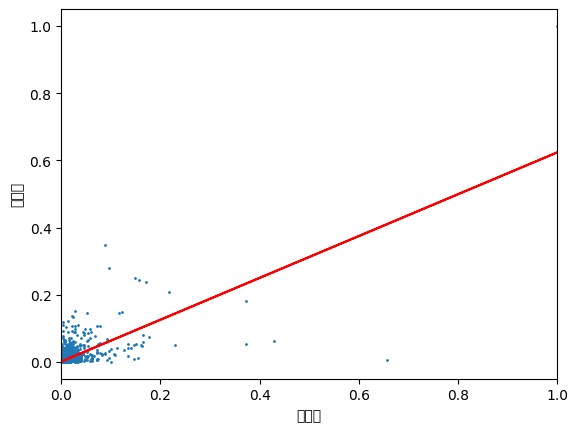

点赞量与评论量的相关性:
               like_count  comment_count
like_count       1.000000       0.710169
comment_count    0.710169       1.000000


In [14]:
# 归一化点赞量和评论量
scaler = MinMaxScaler()
video_df[['like_count', 'comment_count']] = scaler.fit_transform(video_df[['like_count', 'comment_count']])

# 计算相关性
correlation = video_df[['like_count', 'comment_count']].corr()

print('散点图')
x = video_df['like_count']
y = video_df['comment_count']
plt.scatter(x, y, s=1)
# 设置横轴范围
plt.xlim(0, 1)
plt.xlabel('点赞量')
plt.ylabel('评论量')

# 拟合直线
fit = np.polyfit(x, y, 1)  # 拟合一次多项式（即直线），返回拟合的系数
fit_fn = np.poly1d(fit)  # 根据拟合系数生成对应的多项式函数对象
plt.plot(x, fit_fn(x), 'r')  # 绘制拟合直线，颜色设置为红色（'r'）

plt.show()

# 打印相关性矩阵
print("点赞量与评论量的相关性:")
print(correlation)

(c) 对比分析

C:\Users\86136\AppData\Local\Temp\ipykernel_83620\3864637377.py:45: UserWarning: Glyph 20197 (\N{CJK UNIFIED IDEOGRAPH-4EE5}) missing from current font.
  plt.tight_layout()
C:\Users\86136\AppData\Local\Temp\ipykernel_83620\3864637377.py:45: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  plt.tight_layout()
e:\anaconda3\envs\py385\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20197 (\N{CJK UNIFIED IDEOGRAPH-4EE5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
e:\anaconda3\envs\py385\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


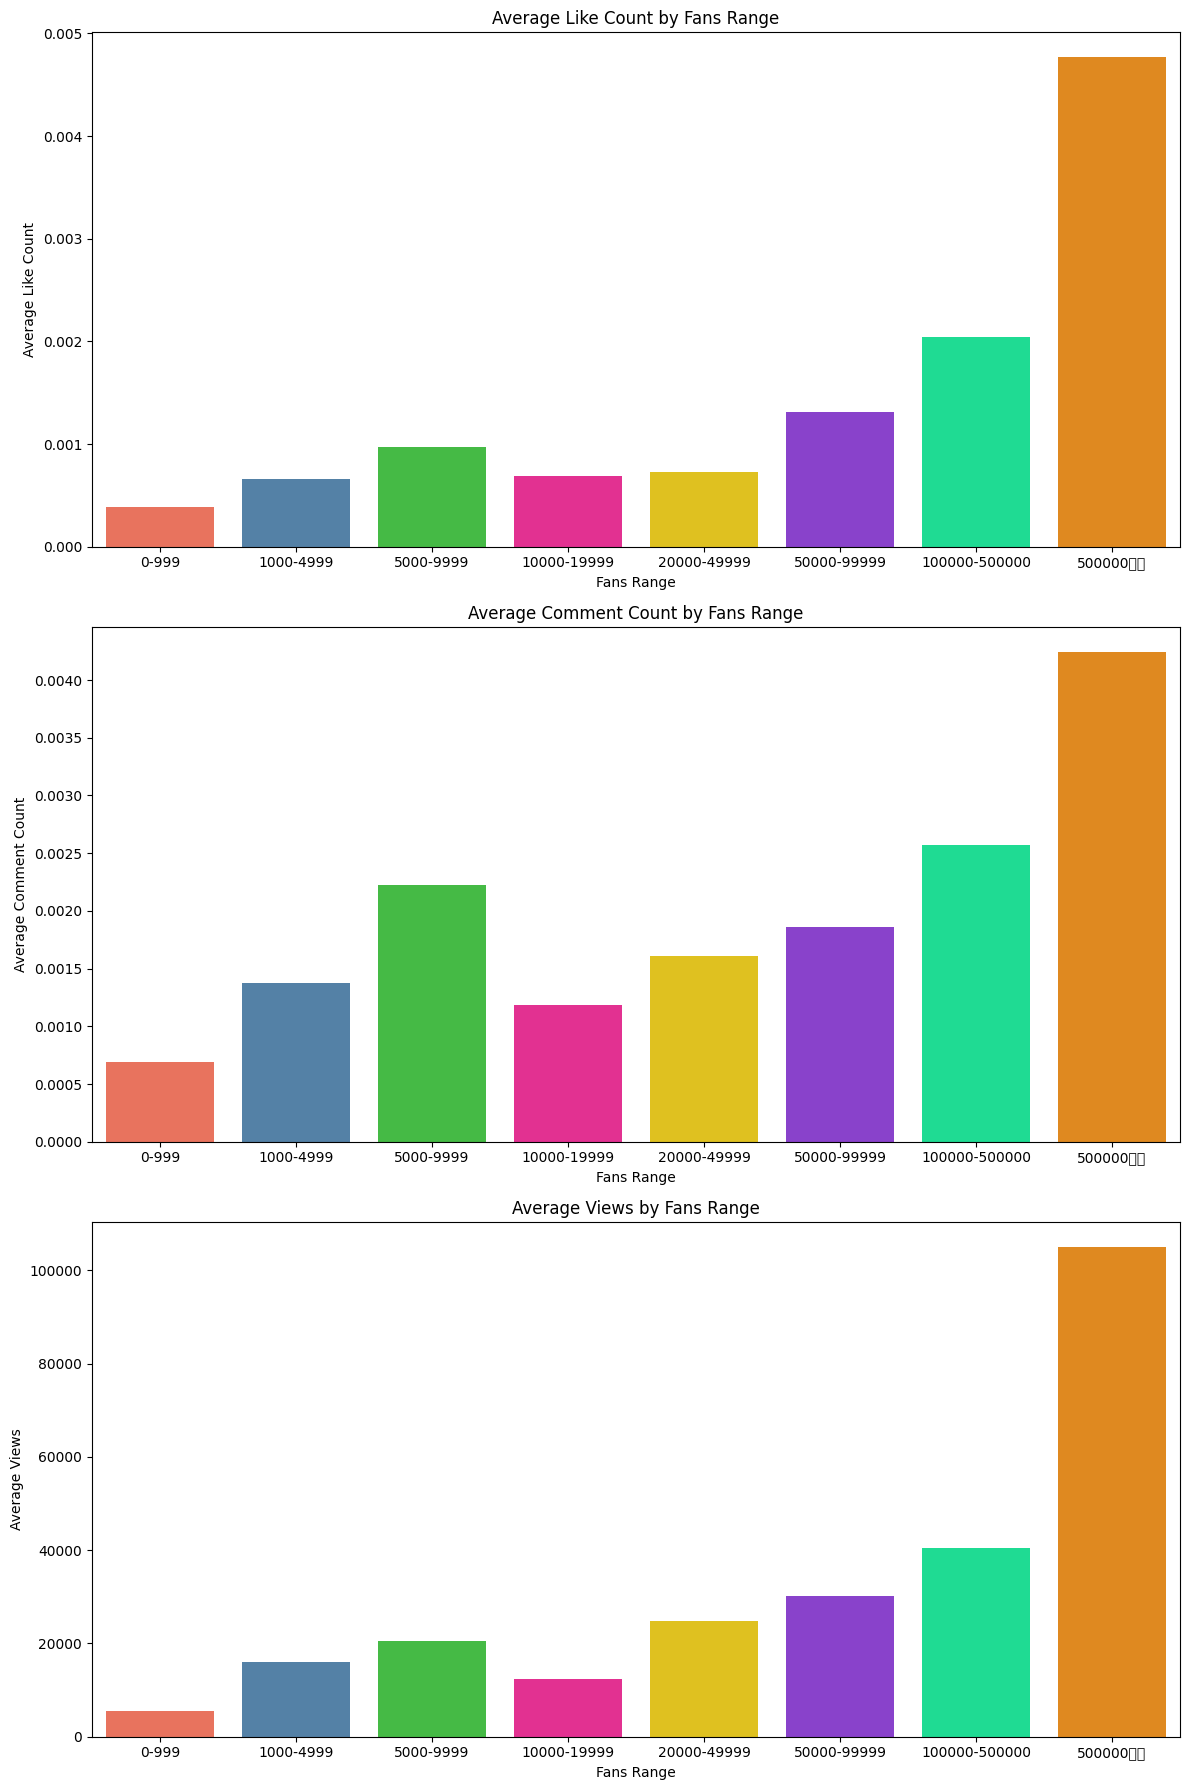

In [15]:
# 确保 author_id 列的类型相同
video_df['author_id'] = video_df['author_id'].astype(str)
author_df['author_id'] = author_df['author_id'].astype(str)

# 合并作者和视频数据
df = pd.merge(video_df, author_df[['author_id', 'fans_count']], on='author_id', how='left')

# 划分粉丝量区间
bins = [0, 999, 4999, 9999, 19999, 49999, 99999, 500000, float('inf')]
labels = ['0-999', '1000-4999', '5000-9999', '10000-19999', '20000-49999', '50000-99999', '100000-500000', '500000以上']
df['fans_range'] = pd.cut(df['fans_count'], bins=bins, labels=labels, right=False)

# 计算每个档次的博主的平均点赞数、平均评论数和平均视频播放量
fans_grouped = df.groupby('fans_range').agg({
    'like_count': 'mean',  # 平均点赞数
    'comment_count': 'mean',  # 平均评论数
    'play_count': 'mean',  # 平均视频播放量
}).reset_index()

# 创建绘图
fig, ax = plt.subplots(3, 1, figsize=(12, 18))
# 自定义颜色列表
custom_palette = [
    '#FF6347', '#4682B4', '#32CD32', '#FF1493', '#FFD700', '#8A2BE2', '#00FA9A', '#FF8C00'
]
# 绘制平均点赞数条形图
sns.barplot(x='fans_range',hue='fans_range', y='like_count', data=fans_grouped, ax=ax[0], palette=custom_palette)
ax[0].set_title('Average Like Count by Fans Range')
ax[0].set_xlabel('Fans Range')
ax[0].set_ylabel('Average Like Count')

# 绘制平均评论数条形图
sns.barplot(x='fans_range',hue='fans_range', y='comment_count', data=fans_grouped, ax=ax[1], palette=custom_palette)
ax[1].set_title('Average Comment Count by Fans Range')
ax[1].set_xlabel('Fans Range')
ax[1].set_ylabel('Average Comment Count')

# 绘制平均视频播放量条形图
sns.barplot(x='fans_range', hue='fans_range',y='play_count', data=fans_grouped, ax=ax[2], palette=custom_palette)
ax[2].set_title('Average Views by Fans Range')
ax[2].set_xlabel('Fans Range')
ax[2].set_ylabel('Average Views')

# 调整布局
plt.tight_layout()
plt.show()

可以看出:
- 随着粉丝范围的增加，平均点赞数、平均评论数和平均观看数都呈现出上升的趋势。
- 在粉丝数较少的范围内（如 0 - 99），这些指标都非常低。
- 当粉丝数超过 500000 时，平均点赞数、平均评论数和平均观看数都有显著的增长，表明粉丝数量多的创作者或内容在这些互动指标上表现更为突出。

这些数据可以帮助创作者了解粉丝数量与内容互动（点赞、评论和观看）之间的关系，从而制定更有效的内容策略。

# (e) 评论分析：词云图

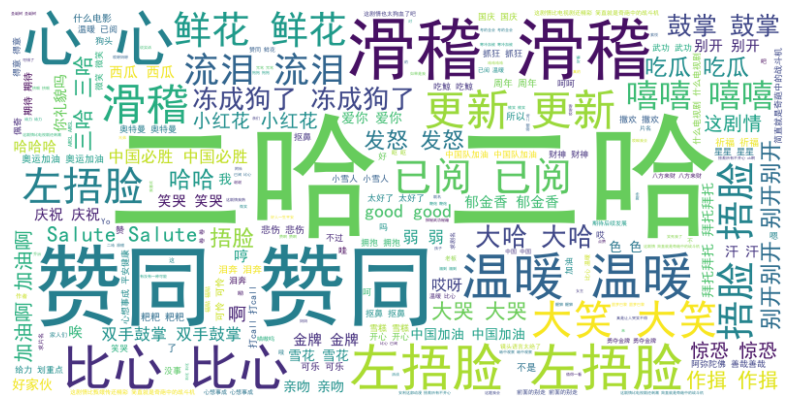

In [16]:


# 生成所有评论的文本
comments_text = " ".join(comment_df['content'].dropna())

# 设置中文字体路径（Windows 默认黑体）
wordcloud = WordCloud(width=800, height=400, background_color="white", font_path="C:\\Windows\\Fonts\\simhei.ttf").generate(comments_text)

# 显示词云图
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


对该词云图进行分析，可以发现出现评论较高的的词组大多是一些情感词，猜测这应该是该平台表情包的称谓。该平台所有表情代码如下：
```
[微笑][开心][期待][大笑][鼓掌][悠闲][笑哭][不要啊][啊][哟][汗][抠鼻][哼][发怒][委屈][不高兴][囧][惊哭][大哭][流泪][害羞][骷髅][衰][咒骂][抓狂][鄙视][再见][哈欠][睡觉][偷笑][你懂的][阴险][白眼][三哈][二哈][大哈][晕][疑问][得意][舔屏][色][亲亲][嘘][闭嘴][呆][什么鬼][吐][已阅][同上][友军][爱钱][Freestyle][国宝][羊驼][鲜花][中国加油][庆祝][生日蛋糕][MicDrop][赞同][药丸][蜡烛][鸡蛋][射门][飞机][火车][车票][饺子][财神][鞭炮][红包][福][2018][666][左捂脸][捂脸][滑稽][嘿哈][没眼看][坏笑][尬笑][打call][浪][红牌][黄牌][哨子][比分][啤酒][足球][大力神杯][锦鲤][双手鼓掌][火焰][祈福][亲吻][天使][樱花][加油][泡泡枪][气球][棒棒糖][小黄鸭][粽子][70周年][🍉][⚡][奥特曼][带着微博去旅行][→_→][爱你][🙏][月亮][n95口罩][🙋][🙊][中国][勤洗手][加油][樱花][加油啊][戴口罩][天使][亲吻][舞狮][鼠年大吉][祈福][火焰][钱袋][灯笼][双手鼓掌][锦鲤][2020][小老鼠][大力神杯][足球][铃铛][圣诞袜][啤酒][比分][圣诞树][圣诞老人][哨子][黄牌][红牌][国庆][国庆快乐][🍗][🎄][👏][👻][💊][💣][💩][🤓][🤗][👿][😱][🙃][🙅][🙈][🙉][🙊][🙋][🙏][爱你][奥特曼][兔子][太开心][酸][生病][伤心][沙尘暴][女孩儿][男孩儿][绿丝带][礼物][挤眼][话筒][给你小心心][给力][干杯][感冒][浮云][肥皂][点亮平安灯][微风][围脖][围观][武汉加油][下雨][音乐][赞啊][炸鸡腿][照相机][钟][猪头][good][抱抱][悲伤][并不简单][馋嘴][吃瓜][打脸][顶][费解][NO][haha][作揖][左哼哼][右哼哼][耶][心][嘻嘻][握手][摊手][思考][失望][弱][拳头][喵喵][来][困][可怜][互粉][黑线][跪了][ok][欧耶][嫌弃][惊恐][社会][ok啊][撇嘴][emmm][暗中观察][拒绝][观望][苦思冥想][奥利给][挠头][凝视][无所谓][摸头][nonono][握草][苦笑][云喝酒][牛斯拉][云红包][牛福到][牛年大吉][2021][雪花][粽子][大红花][锦旗][稻草人][农民][工人][石化][额][泪奔][呕][戳脸][走你][饮酒醉][温暖][Salute][叹气][裂开][吃鲸][比心][AWSL][打工人][小红花][金牌][牛啤][星星][半星][虎年大吉][虎妞妞][小脑斧][银牌][铜牌][滑雪][高考加油][西瓜][可乐][雪糕][考的全会][锦鲤附体][高考必胜][金榜题名]
```
可以看出其都由`[]`包裹，这在哔哩哔哩抖音等社交媒体平台很常见，在某些平台甚至会把`[]`转为`【】`以防止表情的歧义，因此我们通过正则表达式来去除掉`[]`中的内容，并统计词频，得到如下结果：


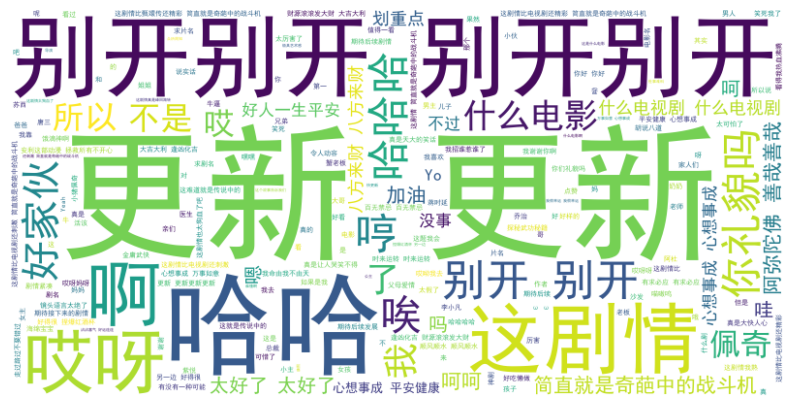

In [ ]:

import re
# 定义正则表达式模式来匹配表情包代码
pattern = re.compile(r'\[.*?\]')
# 对每个评论进行处理
comments_text = " ".join([re.sub(pattern, "", comment) for comment in comment_df['content'].dropna()])

# 设置中文字体路径（Windows 默认黑体）
wordcloud = WordCloud(width=800, height=400, background_color="white", font_path="C:\\Windows\\Fonts\\simhei.ttf").generate(comments_text)

# 显示词云图
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

这个影视区的词云反映了观众对剧情、角色、更新情况的关注，同时也体现了他们在观看过程中的各种情绪。